# Exercise 4

In this exercise, we will work with the MNIST dataset. The dataset contains images of hand-written digits, along with the ground-truth labels (the digit that an image represents).

In [7]:
from torchvision.datasets import MNIST

The MNIST dataset is structured into a training set and a validation set, which we can load separately:

In [8]:
train_data = MNIST('.', download=True, train=True)
val_data = MNIST('.', download=True, train=False)

We can inspect the structure of the dataset:

In [9]:
print("len(train_data):", len(train_data))
print("len(val_data):", len(val_data))
print()
first_sample = train_data[0]
print("type(first_sample):", type(first_sample))
print("len(first_sample):", len(first_sample))
print("type(first_sample[0]):", type(first_sample[0]))
print("type(first_sample[1]):", type(first_sample[1]))
print()

image = first_sample[0]
label = first_sample[1]

print("Image size:", image.size)
print("Label:", label)

len(train_data): 60000
len(val_data): 10000

type(first_sample): <class 'tuple'>
len(first_sample): 2
type(first_sample[0]): <class 'PIL.Image.Image'>
type(first_sample[1]): <class 'int'>

Image size: (28, 28)
Label: 5


As we can see, we can load samples from the dataset with the `[]` operator, and each sample is a tuple with an image and the corresponding label.

## Plotting the data

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Visualizing the data is always a good idea:

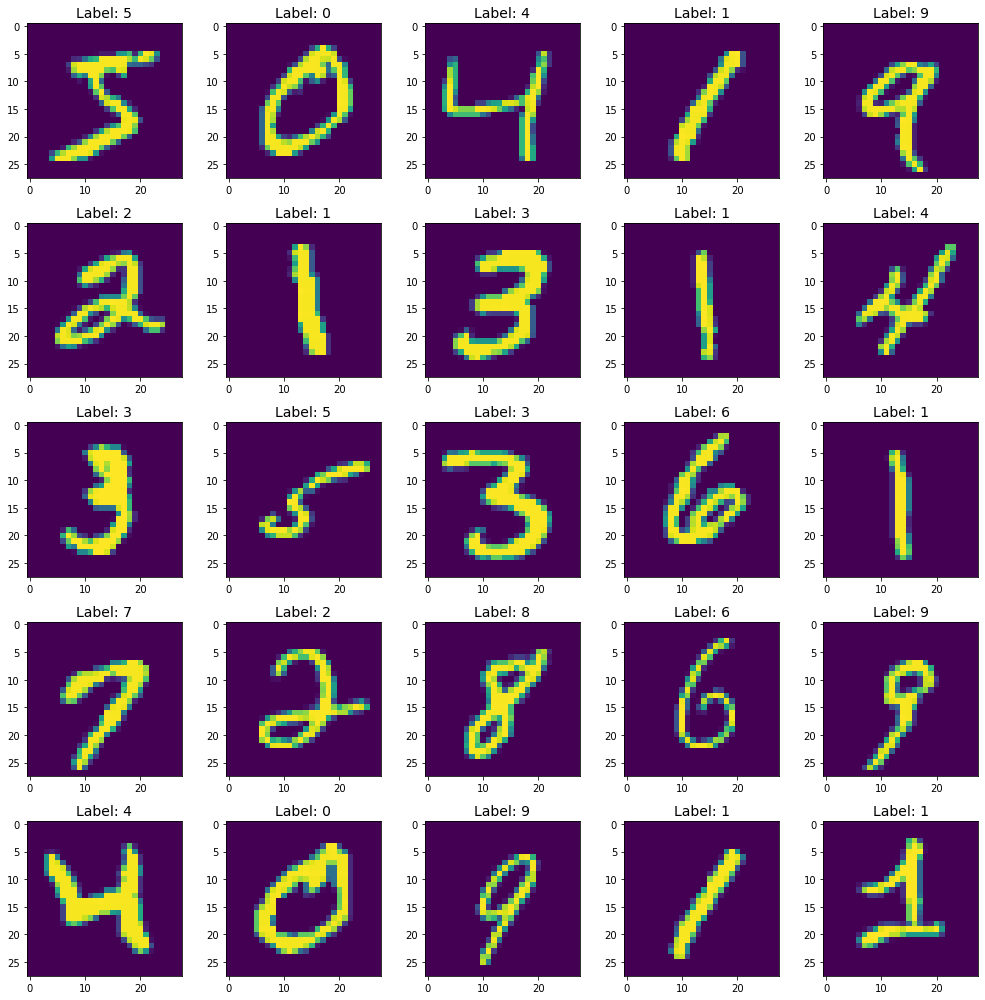

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(14, 14))
for i in range(25):
    image, label = train_data[i]
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"Label: {label}", fontdict={"fontsize": 14})
plt.tight_layout()
plt.show()

## LeNet implementation

We will use a quite simple network to learn digit recognition. The LeNet architecture has just two convolutional layers and two linear layers, along with a couple of nonlinear activations and two pooling layers. The following code implements the network using PyTorch:

In [12]:
import torch
from torch import nn

class LeNet(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(LeNet, self).__init__()

        # first convolution layer + activation + max pooling
        self.conv1 = nn.Conv2d(input_shape[0], 20, (5, 5))
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        # second convolution layer + activation + max pooling
        self.conv2 = nn.Conv2d(20, 50, (5, 5))
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # first linear layer + activation
        self.conv_output_len = (50*4*4)
        self.linear1 = nn.Linear(self.conv_output_len, 500)
        self.act3 = nn.ReLU()
        
        # final linear layer to produce the correct number of outputs
        self.linear2 = nn.Linear(500, num_classes)

    def forward(self, x):
        # perform convolution -> activation -> pooling
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        
        # flatten the features obtained from the conv layers: (BATCH_SIZE, 50, 4, 4) -> (BATCH_SIZE, 50*4*4)
        batch_size = x.shape[0]
        x = x.view(batch_size, self.conv_output_len)
        
        # final linear layers and activations
        x = self.act3(self.linear1(x))
        x = self.linear2(x)
        
        return x

Some notable changes from the LeNet implementation in the original paper are the use of ReLU instead of sigmoid/tanh activations, use of Max Pooling instead of Average Pooling and the number of filters / parameters used in the layers (to allow direct application to the MNIST images without upscaling to 32x32 pixels).

Note that the network does not contain a softmax activation on the final layer, as we will use the `cross_entropy` loss function from PyTorch lateron, which works on the raw logits directly, and yields incorrect results when a softmax operation is applied beforehand.

## Torchvision version check

torchvision < 0.6.0 has a bug when using the RandomRotation class (see https://github.com/pytorch/vision/pull/1828), which is required for one of the tasks below. The following code checks if you are using a recent version of torchvision. If it prints out that you should upgrade, make sure to install the latest torchvision with pip or conda (see setup_instructions.pdf from exercise 1)!

In [13]:
import torchvision
from packaging import version
import logging

print("torchvision version:", torchvision.__version__)
if version.parse(torchvision.__version__) < version.parse('0.6.0a0'):
    logging.error("You seem to be running an old version of torchvision, please upgrade to the latest version!")
else:
    print("torchvision version seems to be fine.")

torchvision version: 0.6.0
torchvision version seems to be fine.


## Training

The following code implements a training and validation loop. In each epoch, one iteration over the training set is performed, followed by one iteration over the validation set. This allows us to check the training and validation loss and classification accuracy in each epoch, which is useful to spot overfitting.

As the point of this exercise is to show you the effect of overfitting and how to combat it, we use only a very small subset of the training data. This leads to the network quickly overfitting quite heavily on the training data and thus not generalizing.

In [14]:
from torchvision.transforms import ToTensor, RandomRotation, Compose
from torch.nn.functional import cross_entropy
import numpy as np
import tqdm
from math import ceil
import random

NUM_EPOCHS = 100
BATCH_SIZE = 10
NUM_CLASSES = 10
LR = 0.001

random.seed(0)
torch.manual_seed(0)
model = LeNet(NUM_CLASSES, (1, 28, 28))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Adam optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.001)

num_train_images = 100 # len(train_data)
num_val_images = 100 # len(val_data)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

BATCH_SIZE = 50

# This loader generates batches of data according to BATCH_SIZE
# It also applies a `transform` function to the image (see below)
def Loader(data, num_samples, transform, BATCH_SIZE=BATCH_SIZE):
    NUM_BATCHES = int(ceil(num_samples/BATCH_SIZE))
    
    # This generates the batches, one after another
    for i in range(NUM_BATCHES):
        indices = range(i*BATCH_SIZE, min((i+1)*BATCH_SIZE, num_samples))
        batch = [data[i] for i in indices]
        
        # convert PIL image and label to PyTorch tensors
        images = torch.stack([transform(item[0]) for item in batch])
        labels = torch.stack([torch.tensor(item[1]) for item in batch])
        yield images, labels

# Image transforms
# ToTensor converts a PIL image to a PyTorch tensor
# It also swaps the order of the image channels, e.g. (28, 28, 3) to (3, 28, 28)
# Also, the pixel values are normalized to be between 0 and 1 (instead of between 0 and 255)
# See https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor
train_transform = ToTensor()
val_transform = ToTensor()

for epoch in range(NUM_EPOCHS):
    # perform training followed by validation
    for mode, data, num_samples, transform in [
        ("train", train_data, num_train_images, train_transform),
        ("val", val_data, num_val_images, val_transform)
    ]:
        # progressbar setup
        num_batches = int(ceil(num_samples/BATCH_SIZE))
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train() # do calculate gradients for training mode
        else:
            model.eval() # do not calculate gradients in validation mode

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0
        
        # loop over the data
        for i_batch, batch in enumerate(Loader(data, num_samples, transform)):
            images, labels = batch
            # move tensors to the correct device
            images = images.to(device)
            labels = labels.to(device)

            # run the model
            predictions = model.forward(images)

            # loss calculation
            loss = cross_entropy(predictions, labels)

            # calculate the metrics for the progress bar
            num_batch_samples = len(images)
            runningLoss += loss.item() * num_batch_samples
            correct_predictions += (torch.argmax(predictions, dim=-1) == labels).sum().item()
            total_samples += num_batch_samples
            
            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples
            })

            # weight update
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()

val epoch 99: 100%|██████████| 2/2 [00:00<00:00, 182.30it/s, loss=0.897, accuracy=0.74]


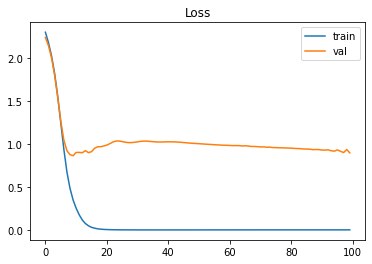

In [15]:
plt.title("Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

We can see that the training loss quickly approaches zero, while the validation loss first decreases, but increases when the network starts to overfit on the training data.

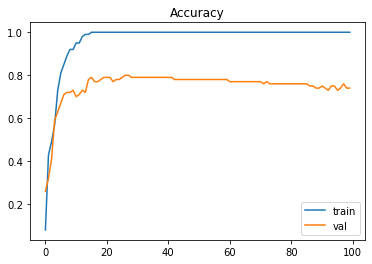

In [16]:
plt.title("Accuracy")
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.legend()
plt.show()

The accuracy on the training data quickly reaches 100%, while the validation accuracy stays at about 80%, slightly decreasing.

## Visualizing results

We can also visualize the predictions of the network on the training set. Note that now we have to use the softmax operation on the model's results, if we want to obtain classification probabilities.

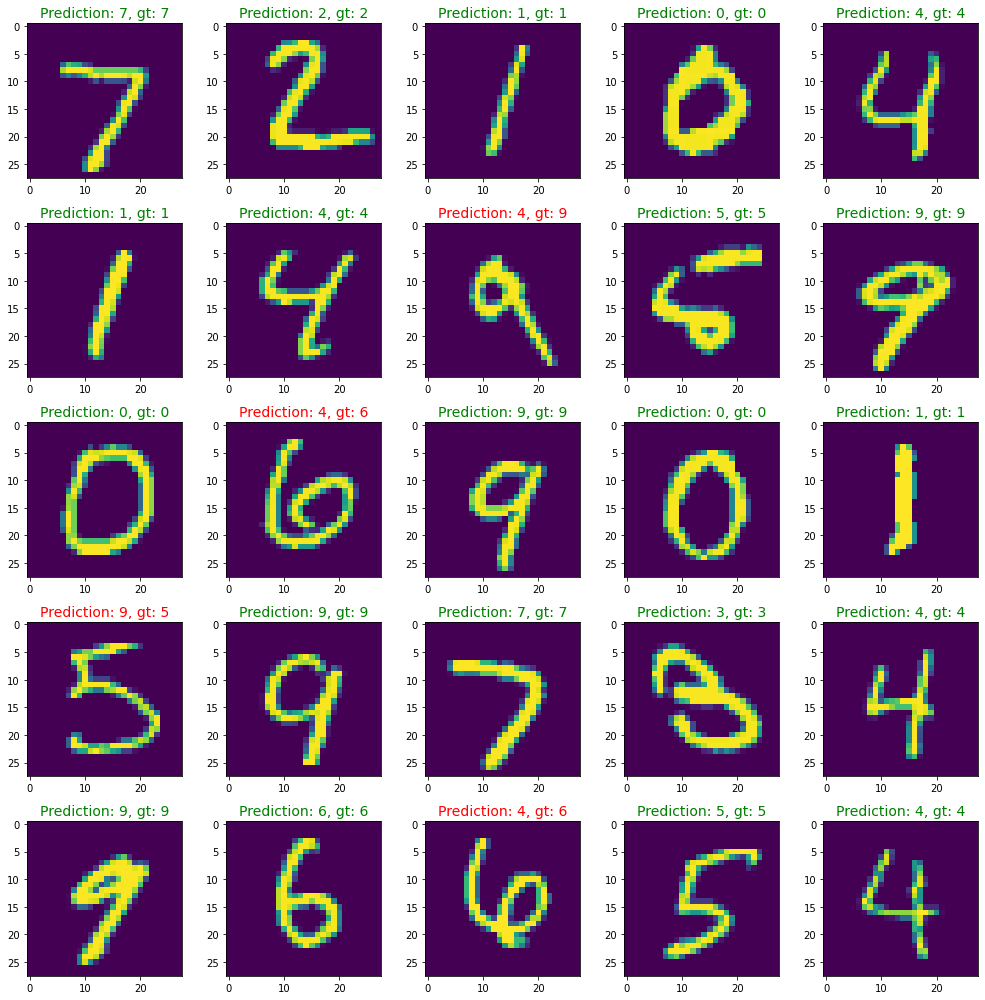

In [17]:
from torchvision.transforms.functional import to_pil_image

num_test_samples = 25
images, labels = next(Loader(val_data, num_test_samples, transform=val_transform, BATCH_SIZE=num_test_samples))

num_cols = 5
num_rows = int(ceil(num_test_samples/num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

model.eval()
predictions = model(images.to(device))
scores = nn.functional.softmax(predictions, dim=-1)
predicted_classes = torch.argmax(scores, dim=-1)
# actually if we only need the index of the class with the highest probability, we could omit the softmax operation and perform argmax on the logits directly.
# predicted_classes = torch.argmax(predictions, dim=-1)

for i in range(num_test_samples):
    image, label = images[i], labels[i]
    predicted_class = predicted_classes[i].cpu().item()
    
    # convert the pytorch tensor back to a PIL image
    image = to_pil_image(image)
    
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(image)
    ax.set_title(f"Prediction: {predicted_class}, gt: {label}", fontdict={"fontsize": 14, "color": ("green" if predicted_class == label else "red")})
plt.tight_layout()
plt.show()

## Tasks

The tasks are now to combat the overfitting with data augmentation, normalization and/or regularization. For each of the following tasks, copy this notebook and rename it according to the task:
- Modify the `train_transform` to perform a random rotation of the image before passing it to ToTensor. You can use the [RandomRotation](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation) class for this. To combine the rotation transform with the `ToTensor` transform, use the [Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) class. Make sure to only modify `train_transform` and not `val_transform`, as we do not want to perform random rotations on the validation set.
- Introduce a weight decay (L2 penalty) of 0.001 by passing a `weight_decay` parameter to the Adam optimizer. See [Adam documentation](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).
- Modify the network structure to perform BatchNormalization after each convolution operation. You can use the [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) class for this.
- Modify the network structure by adding a Dropout layer between the linear layers. Use a dropout probability of 50%. You can use the  [Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) class for this.

In each notebook, adjust the name of the pickle file in the following code:

In [18]:
import pickle
with open("1_l2.pickle", "wb") as f:
    pickle.dump([train_losses, val_losses], f)

Then, you can compare the results of the different methods to combat overfitting:

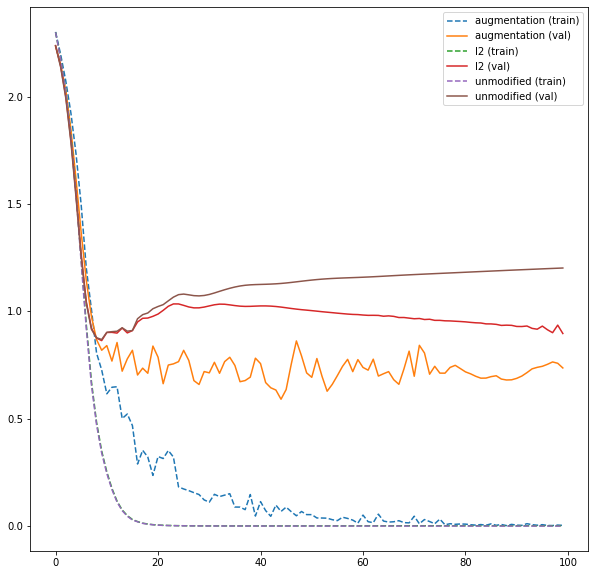

In [21]:
import glob

plt.figure(figsize=(10, 10))
for f in sorted(glob.glob('*.pickle')):
    with open(f, 'rb') as handle:
        train_losses, val_losses = pickle.load(handle)
    label = " ".join(f.split('.')[0].split('_')[1:])
    plt.plot(train_losses, '--', label=f"{label} (train)")
    plt.plot(val_losses, label=f"{label} (val)")

# plt.yscale('log')
plt.legend()
plt.show()

You can get the "everything" graph by creating a notebook that combines the changes of all four tasks.

We can see that all of the above changes decrease the final validation loss. We get the highest reduction when combining all changes, as they all help to combat overfitting and aid generalization.

## Bonus tasks

- In practise, you will often work with custom data formats and thus have to implement custom transforms to perform data augmentation on your data. Creating a custom transform is quite easy. For this task, code the random image rotation transformation in your own custom transform class. You can use the following code to get started:
```python
class MyTransform(object):
    def __init__(self, arguments):
        # initialization code here
        pass
    
    def __call__(self, sample):
        # This method gets called on each sample
        # apply transform to the image
        # sample is a tuple with (image, label)
        pass
```
You can use the `.rotate` method of the PIL image to rotate it by a given number of degrees, which you can choose randomly using the `random` module.
- Instead of using the `weight_decay` parameter of your favorite optimizer, switch out the PyTorch Adam optimizer for an optimizer implementation from the last exercise, and add a L2 penalty to the loss calculation.
- Switch out the MNIST dataset for the FashionMNIST dataset (also included in torchvision)
- Remove the limit of 100 samples, and see how your model performs on the full dataset.